# Tweet text analysis

## Importing libraries

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
# For data and matrix manipulation
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import cufflinks as cf
import plotly.graph_objs as go
from plotly.plotly import iplot

# For string manipulation
import re 
import string

# For text pre-processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# For assigning sentiment polarity scores
from textblob import TextBlob

# For extracting features -- i.e. the document-term matrix
from sklearn.feature_extraction.text import CountVectorizer

# For splitting the data into a training and a testing set
from sklearn.model_selection import train_test_split

# For using Naive Bayes - the typical basic machine learning algorithm of choice for Text analytics
from sklearn.naive_bayes import MultinomialNB

# For evaluating our machine learning model 
from sklearn.metrics import accuracy_score, classification_report


# Necessary dependencies from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thomas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

## Load data

In [4]:
df = pd.read_csv('./datasets/apple-tweets.csv')
df.shape

(9991, 88)

In [5]:
df.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
0,5746452.0,1.090000e+18,1548799817,waltmossberg,It’s true that @Apple likely overpriced the la...,Twitter for iPad,279,NaN,NaN,NaN,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
1,5746452.0,1.090000e+18,1548800328,waltmossberg,@AaronSuplizio @Apple Yes it is.,Twitter for iPad,10,1.090000e+18,2.365419e+07,AaronSuplizio,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
2,5746452.0,1.090000e+18,1548802301,waltmossberg,"@mvigod @Apple As I have said many times here,...",Twitter for iPad,259,1.090000e+18,2.224800e+08,mvigod,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
3,5746452.0,1.090000e+18,1548800242,waltmossberg,I’m not saying that @Apple doesn’t have proble...,Twitter for iPad,270,1.090000e+18,5.746452e+06,waltmossberg,...,21783,31007,1178213411,True,https://t.co/AH9VhHsJmY,http://www.theverge.com/label/walt-mossberg-verge,en,https://pbs.twimg.com/profile_banners/5746452/...,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/4637351296...
4,1175221.0,1.090000e+18,1548737368,digiphile,@DaveLeeBBC @Apple @NYGovCuomo Nor I; saw it g...,Twitter for iPhone,88,1.090000e+18,1.251786e+09,DaveLeeBBC,...,165604,108196,1173899540,True,https://t.co/QWOxhaw2kk,https://digiphile.info/about/,en,https://pbs.twimg.com/profile_banners/1175221/...,http://abs.twimg.com/images/themes/theme15/bg.png,http://pbs.twimg.com/profile_images/1076306605...


In [8]:
# Call the text column
tweets = df['text']

tweets

0       It’s true that @Apple likely overpriced the la...
1                        @AaronSuplizio @Apple Yes it is.
2       @mvigod @Apple As I have said many times here,...
3       I’m not saying that @Apple doesn’t have proble...
4       @DaveLeeBBC @Apple @NYGovCuomo Nor I; saw it g...
                              ...                        
9986                                       @Apple Nope...
9987    @JJHannanWriting @Apple Apple has become the s...
9988    I’ve got to say @Apple @tim_cook I love EVERYT...
9989    @CourtMejias @raymondchung @Apple @Honda @Toyo...
9990    Throws @GoogleUK @AmazonUK @Apple into focus #...
Name: text, Length: 9991, dtype: object

## Text preprocessing

Looking above, we can see there's much to be done -- some questions we could ask ourselves:

What do we do with handles? I.e. @Apple
What do we do with punctuation? I.e. !?.-#
How do we handle words spelt incorrectly? I.e. that vs. thattt
What do we do with Emojis? I.e. :), :-) etc.
What about words that have inflectional changes? Do we keep them or return them to their base? See NLP Stanford on Stemming and Lemmatization
It may be a good idea to begin with a sample sententce, and see how we do:

In [32]:
sample = 'This is the pre-processing stages:    @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [33]:
# word_tokenize - transforms our string/text into a list of words (separated by a white space), where each word is 
# called a token.
word_tokenize(sample)

['This',
 'is',
 'the',
 'pre-processing',
 'stages',
 ':',
 '@',
 'ApplE',
 '.',
 '#',
 'whataday',
 'This',
 'is',
 'SOOOO',
 'EXCI~TING',
 '.',
 'Cows',
 '.',
 'Thats',
 'all',
 'i',
 'have',
 'to',
 'say',
 ',',
 ':',
 ')']

In [34]:
# sent_tokenize - transforms our string/text into a list of sentence (separated by a '.'), where each sentence is 
# a token.
sent_tokenize(sample)

['This is the pre-processing stages:    @ApplE.',
 '#whataday This is SOOOO EXCI~TING.',
 'Cows.',
 'Thats all i have to say, :)']

In [35]:
# change letter case
(sample.lower(), sample.upper())

('this is the pre-processing stages:    @apple. #whataday this is soooo exci~ting. cows. thats all i have to say, :)',
 'THIS IS THE PRE-PROCESSING STAGES:    @APPLE. #WHATADAY THIS IS SOOOO EXCI~TING. COWS. THATS ALL I HAVE TO SAY, :)')

In order to capture patterns in our text data, we use a handy tool called _regex_ or regular expressions. This is a whole interesting area of text analytics worthy of exploration. 

For reference on some regular expressions and how to use them: [W3 Schools Regex](https://www.w3schools.com/python/python_regex.asp)

For trialling various regex patterns and combinations on more text:  [Regexr](https://www.regexr.com)

In [36]:
# using regular expressions
# Substitutes a specified characted with another specified character of your choice
re.sub('@', '@@', sample)

'This is the pre-processing stages:    @@ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [37]:
# replace space sequences of any length with 1 space
re.sub('\s+', ' ', sample)

'This is the pre-processing stages: @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [38]:
# remove a list of characters
re.sub('[!?.,:)]', '', sample)

'This is the pre-processing stages    @ApplE #whataday This is SOOOO EXCI~TING Cows Thats all i have to say '

In [39]:
# Using the stemmer function -- what do you notice?
PorterStemmer().stem('I love canaries -- their lives, like all mammals, can be divided in stages')

'i love canaries -- their lives, like all mammals, can be divided in stag'

In [43]:
# Using the lemmatizer function - by default it lemmatizes nouns (pos='n' for nouns), for e.g.:
print(WordNetLemmatizer().lemmatize('cars'))

# But it can also be adjusted to lemmatize adjectives by setting the 'pos' parameter to 'a' for 'adjective':
print(WordNetLemmatizer().lemmatize('better', pos = 'a'))
print(WordNetLemmatizer().lemmatize('wrote', pos = 'v'))

car
good
write


Finally, we may also want to consider exploring 'stopwords'. Those are words like 'and', 'you', and 'I' that add little value to our model and would only clutter our corpus. 

The NLTK Library has a very handy pre-populated dictionary of such words that we can use to our advantage.

They also have a [list of other corpora](http://www.nltk.org/nltk_data/) that may be useful for future text analytics projects!

In [44]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Now that we've played around with text preprocessing and have some idea of what we can do, let's go ahead and put it all in a function.  

Remember we can always go back and change our choices later!

In [53]:
def clean_text(sample_text):
    
    # Given a sample text (as a string), we first substitute a select few sybmols with white space
    sample_text = re.sub(r'[#|@|-|?|!]',r' ',sample_text)
    
    # We then strip extra white space
    sample_text = re.sub('\s+',' ', sample_text)
    
    # Then change everything to lower case
    sample_text = sample_text.lower()
    
    # Then lemmatize our words -- note,  stemming was deemed too crude here, and therefore not chosen
    sample_text = WordNetLemmatizer().lemmatize(sample_text)
    
    # Now that we transformed our text, we need to tokenize it. Let's treat each word as a token.
    words = word_tokenize(sample_text)
    
    # As we now have a list of words,  we can go ahead and find and remove those words that also belong to the 
    # stopwords list from the NLTK corpus
    words = [w for w in words if w not in stopwords.words('english')]
    
    # We then proceed to joining those list of words, back to 'free text'  or string format
    text = ' '.join(words)
    
    return text

In [54]:
print('Our sample string:\t\t{}'.format(sample))
print('Our cleaned sample string:\t{}'.format(clean_text(sample)))

Our sample string:		This is the pre-processing stages:    @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)
Our cleaned sample string:	pre-processing stages : apple . whataday soooo exci~ting . cows . thats say , : )


In [55]:
re.sub(r'[#|@|-|?|!]',r' ',sample)

'This is the pre-processing stages:     ApplE.  whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [56]:
re.sub('\s+',' ', sample)

'This is the pre-processing stages: @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [57]:
WordNetLemmatizer().lemmatize(sample)

'This is the pre-processing stages:    @ApplE. #whataday This is SOOOO EXCI~TING. Cows. Thats all i have to say, :)'

In [58]:
word_tokenize(sample)

['This',
 'is',
 'the',
 'pre-processing',
 'stages',
 ':',
 '@',
 'ApplE',
 '.',
 '#',
 'whataday',
 'This',
 'is',
 'SOOOO',
 'EXCI~TING',
 '.',
 'Cows',
 '.',
 'Thats',
 'all',
 'i',
 'have',
 'to',
 'say',
 ',',
 ':',
 ')']

In [59]:
# We can quickly apply the above function by using the 'apply' and 'lambda' functions as so
tweets = df['text']
tweets = tweets.apply(lambda x: clean_text(x))

# Let's see the results!
tweets

0       ’ true apple likely overpriced latest iphones ...
1                               aaronsuplizio apple yes .
2       mvigod apple said many times , regard multiple...
3       ’ saying apple ’ problems challenges . . ’ say...
4       daveleebbc apple nygovcuomo ; saw go tracked c...
                              ...                        
9986                                       apple nope ...
9987    jjhannanwriting apple apple become scientology...
9988    ’ got say apple tim_cook love everything iphon...
9989    courtmejias raymondchung apple honda toyota go...
9990    throws googleuk amazonuk apple focus tax avoid...
Name: text, Length: 9991, dtype: object

In [60]:
tweets[0]

'’ true apple likely overpriced latest iphones mature market , especially china . therefore overestimated revenues earnings . , people , please remember shortfall meant took “ ” $ 84 billion 90 days instead $ 93 billion .'

## Bag of words

Now that we've cleaned our corpus of tweets, we have put it in a form that can be used by our machine learning models. The model we'll be using is called the **bag of words** model.

This involves creating a document-term matrix -- a matrix with **documents** or tweets as the rows, and unique **terms** as the columns -- which we use the _CountVectorizer()_ function for from the NLTK package. 

In [61]:
# We specify that we need no more than 10000 features -- i.e. 1000 unique terms. Of course, this is an arbitrary number
# feel free to play around with this parameter!

# We also specify the min_df parameter to be 0.01. This means that our terms should at least be used in 1% of our 
# tweets.

# Finally, we specify an ngram_range of 1. This means that we're only looking for words -- an ngram_range of (1,2) 
# would include both words (length = 1) and phrases or combinations of words of length = 2 
vector = CountVectorizer(max_features= 10000 , min_df=0.01, ngram_range= (1,1))

# We use the fit_transform() function to apply the above to our tweets
bag_of_words = vector.fit_transform(tweets)

bag_of_words

<9991x148 sparse matrix of type '<class 'numpy.int64'>'
	with 46204 stored elements in Compressed Sparse Row format>

In [62]:
type(bag_of_words)

scipy.sparse.csr.csr_matrix

In [63]:
# Let's get our terms
vector.get_feature_names()

['100',
 '2019',
 'airpods',
 'already',
 'also',
 'always',
 'amp',
 'android',
 'another',
 'answer',
 'app',
 'apple',
 'applesupport',
 'back',
 'battery',
 'best',
 'better',
 'big',
 'bug',
 'buy',
 'ca',
 'call',
 'camera',
 'change',
 'co',
 'come',
 'company',
 'could',
 'data',
 'day',
 'days',
 'devices',
 'done',
 'even',
 'ever',
 'every',
 'facebook',
 'facetime',
 'feature',
 'first',
 'fix',
 'fuck',
 'get',
 'getting',
 'give',
 'glitch',
 'go',
 'going',
 'good',
 'google',
 'got',
 'great',
 'group',
 'guys',
 'hear',
 'help',
 'hey',
 'https',
 'ios',
 'ipad',
 'iphone',
 'iphones',
 'issue',
 'know',
 'last',
 'let',
 'life',
 'like',
 'listen',
 'lol',
 'look',
 'love',
 'mac',
 'macbook',
 'made',
 'make',
 'many',
 'microsoft',
 'money',
 'much',
 'music',
 'na',
 'need',
 'needs',
 'never',
 'new',
 'next',
 'old',
 'one',
 'pay',
 'people',
 'phone',
 'phones',
 'please',
 'price',
 'privacy',
 'pro',
 'product',
 'products',
 'really',
 'right',
 'said',
 'sa

In [64]:
len(vector.get_feature_names())

148

## Visualisation

There's lots to explore here! Let's begin with a few visualisations that could be of interest. 

In [65]:
# Find the sum of occurences of each term
sum_of_words = bag_of_words.sum(axis= 0)

# Create a list of tuples where each element represents the term in question and how many times it occurs in our 
# corpus.
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]

# Sort in decreasing order of frequency.
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

words_freq

[('apple', 11547),
 ('co', 3521),
 ('https', 3510),
 ('iphone', 1284),
 ('facetime', 1014),
 ('phone', 766),
 ('new', 684),
 ('like', 629),
 ('get', 592),
 ('tim_cook', 546),
 ('fix', 518),
 ('applesupport', 507),
 ('bug', 478),
 ('one', 469),
 ('amp', 414),
 ('people', 408),
 ('need', 399),
 ('would', 393),
 ('time', 384),
 ('make', 369),
 ('please', 352),
 ('got', 350),
 ('shit', 349),
 ('app', 338),
 ('even', 314),
 ('still', 311),
 ('privacy', 299),
 ('google', 295),
 ('update', 291),
 ('know', 287),
 ('really', 286),
 ('android', 285),
 ('use', 276),
 ('back', 272),
 ('good', 269),
 ('want', 266),
 ('think', 256),
 ('ios', 253),
 ('watch', 248),
 ('see', 239),
 ('going', 237),
 ('us', 236),
 ('better', 232),
 ('call', 231),
 ('work', 229),
 ('love', 228),
 ('shotoniphone', 226),
 ('much', 224),
 ('go', 220),
 ('right', 220),
 ('could', 219),
 ('way', 211),
 ('ipad', 209),
 ('thanks', 204),
 ('buy', 194),
 ('facebook', 186),
 ('phones', 186),
 ('answer', 186),
 ('well', 185),
 ('gr

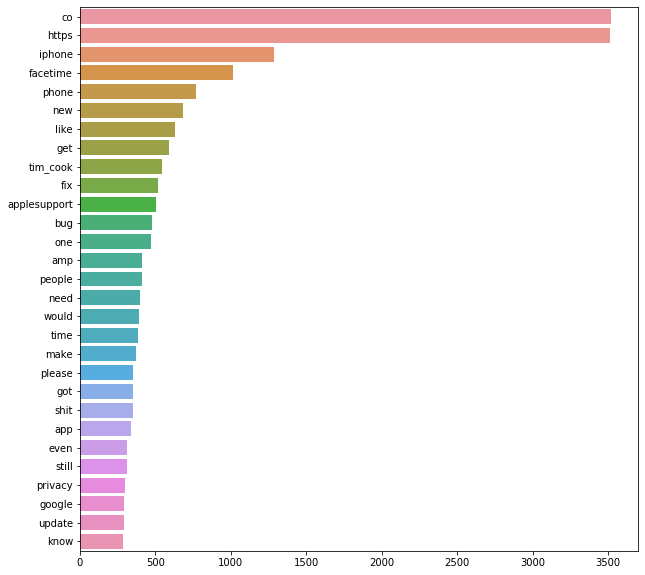

In [79]:
# Ignoring top word (which is "apple" in this case)
top_words = words_freq[1:30]

word = []
count = []

for i, j in top_words: 
    word.append(i)
    count.append(j)

# Asjusting figure size
plt.figure(figsize = (10,10))

# Plotting a barplot of most frequent words using Seaborn
sns.barplot(x = count, y = word)

In [77]:
def plot_wordclouds(top_words):
    # Another way to plot most frequent words is through use of Wordclouds
    words_dict = {}
    for k,v in top_words:
        words_dict[k] = int(v)

    # Using the WordCloud library
    wordcloud = WordCloud(width=2000, height=700, background_color="white").generate_from_frequencies(words_dict)

    plt.figure(figsize=(25, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

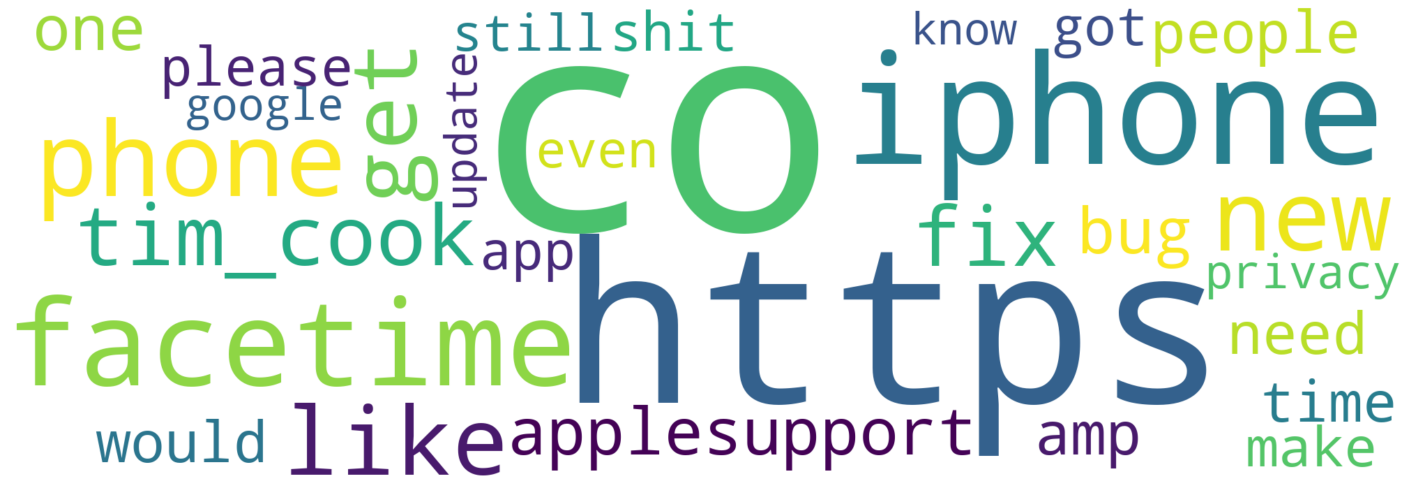

In [80]:
plot_wordclouds(top_words)

In [81]:
# It's clear that some terms like 'https' and 'co' refer to URLS and are not very useful to us. We can go about 
# removing them as so:
top_words.remove(('https', 3510))

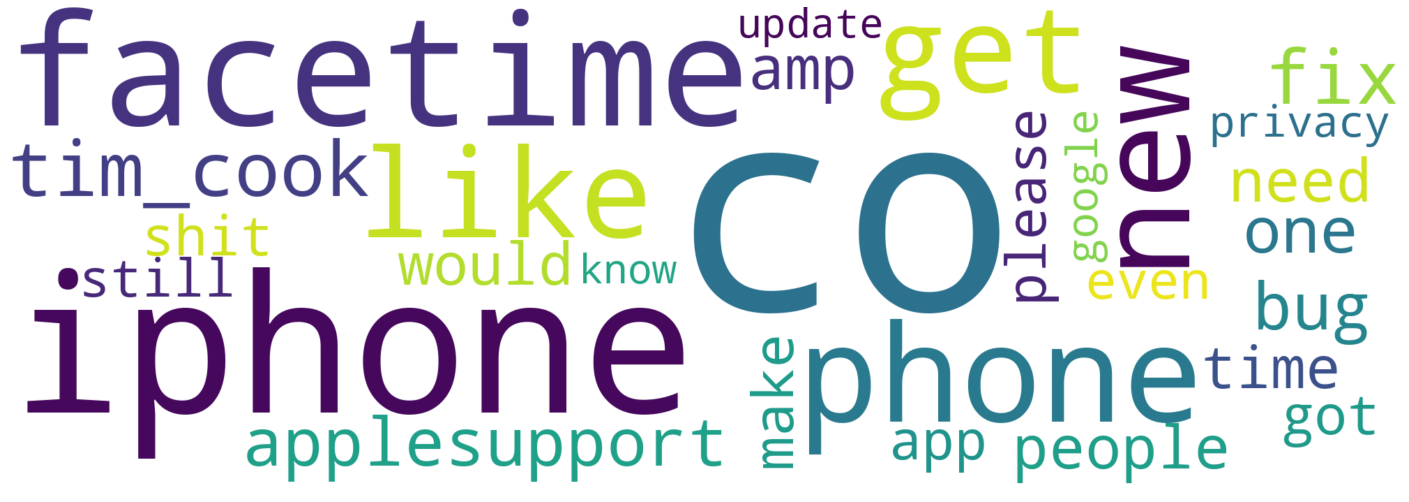

In [82]:
plot_wordclouds(top_words)

Now that we visualised most frequent words, we can delve into more interesting aspects, like sentiment. 


To do this, we'll be using a library called **Textblob**. The package assigns a _sentiment polarity score_ from -1 to 1 to each of our words. It then calculates the sum total sentiment polarity for each tweet by averaging the scores for the terms in the tweet in question. 

Textblob assigns sentiment scores based on pre-populated lexicon, or dictionary of words that have been previously assigned scores by humans -- no magic here! For more information on how the scoring is calculated read more [here](https://planspace.org/20150607-textblob_sentiment/). 

In [83]:
# We create a list of sentiment scores on each of our tweets using Textblob
sentiments = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    sentiments.append(analysis.sentiment.polarity)

# We add that list to a new dataframe of our tweets
tweets_df = pd.DataFrame(tweets)

tweets_df['sentiments'] = sentiments

tweets_df.head()

,text,sentiments
0,’ true apple likely overpriced latest iphones ...,0.19
1,aaronsuplizio apple yes .,0.00
2,"mvigod apple said many times , regard multiple...",0.00
3,’ saying apple ’ problems challenges . . ’ say...,0.00
4,daveleebbc apple nygovcuomo ; saw go tracked c...,0.00


In [85]:
tweets_df.sort_values(['sentiments'], ascending=False).head(10)

,text,sentiments
1023,technologyjock apple awesome sunder,1.0
6633,whoa apple 's best raidernation ⁦ raiders⁩ htt...,1.0
7636,apple iphone greatest mobile world never give ...,1.0
178,got file 😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌 ’ b...,1.0
4826,"apple billboard banner , perfect timing . face...",1.0
8829,michaelkammes sfcutters apple lacpug hmm . 's ...,1.0
4848,adaniels3po needs partner google/apple maps c-...,1.0
9906,'s awesome photo dwayne tim_cook stregisdc app...,1.0
3970,gauravkheterpal apple help tab ... .. priceles...,1.0
1719,"apple shittiest iphone best offer , nah . 'm `...",1.0


Quite a fair amount of errors, see tweet #1719 for instance!

In [97]:
df.loc[1719, 'text']

'@Apple If the shittiest iPhone is the best you have to offer, then nah. I\'m not up for an "upgrade" into a 720p display'

In [86]:
tweets_df.sort_values(['sentiments'], ascending=True).head(10)

,text,sentiments
4943,evil bastards apple ’ make computers usa -they...,-1.0
4662,"terrible everyone , disable facetime apple nee...",-1.0
8413,apple please make smoothing pictures selfie ca...,-1.0
6804,"dear apple , q4 result $ 9b slowdown iphone sa...",-1.0
9217,apple worst ad ever,-1.0
8525,vzwsupport either apple need fix conference ca...,-1.0
2279,apple `` bug '' allows eavesdropping phones . ...,-1.0
1582,apple worst advertisement ever,-1.0
4817,tamrynsher absolutely disgusting apple myistor...,-1.0
3213,insane . ever heard cybersecurity apple https ...,-1.0


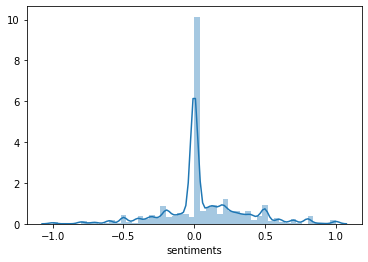

In [94]:
# let's check the distribution of our sentiments
sns.distplot(tweets_df['sentiments'])

In [96]:
# another lexicon which can be more powerful is VADER (lexicon by NLTK)

In [ ]:
# from there we can predict sentiments for new tweets unseen by our bag of words model.

In [98]:
# word2vec & doc2vec would be better to capture context of a text